# Machine Learning for Flow Cytometry

One of the directions `cytoflow` is going in that I'm most excited about is the application of advanced machine learning methods to flow cytometry analysis.  After all, cytometry data is just a high-dimensional data set with many data points: making sense of it can take advantage of some of the sophisticated methods that have seen great success with other high-throughput biological data (such as microarrays.)

The following notebook demonstrates a heavily-commented machine learning method, Gaussian Mixture Models, applied to the demo data set we worked with in "Basic Cytometry."  Then, there are briefer examples of some of the other machine learning methods that are implemented in `cytoflow`.

Set up the Jupyter notebook and import `cytoflow`.

In [1]:
# in some buggy versions of the Jupyter notebook, this needs to be in its OWN CELL.
%matplotlib inline

In [2]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

We have two `Tube`s of data that we specify were treated with two different concentrations of the inducer Doxycycline.

In [3]:
tube1 = flow.Tube(file = 'data/RFP_Well_A3.fcs',
                  conditions = {"Dox" : 10.0})
tube2 = flow.Tube(file='data/CFP_Well_A4.fcs',
                  conditions = {"Dox" : 1.0})

import_op = flow.ImportOp(conditions = {"Dox" : "float"},
                          tubes = [tube1, tube2],
                          channels = {'V2-A' : 'V2-A',
                                      'Y2-A' : 'Y2-A'})

ex = import_op.apply()

Let's look at the histogram of the `Y2-A` channel (on a `logicle` plot scale).

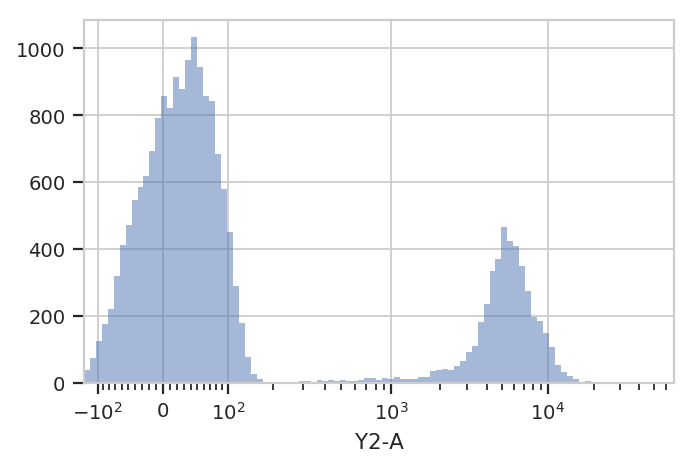

In [4]:
flow.HistogramView(scale = 'logicle',
                   channel = 'Y2-A').plot(ex)

This data looks bimodal to me!  Not perfect Gaussians, but close enough that using a Gaussian Mixture Model will probably let us separate them.

Let's use the `GaussianMixtureOp` to separate these two populations.  In operations that are paramterized by data (either an Experiment or some auxilliary FCS file), `cytoflow` separates the estimation of module parameters from their application.  Thus, after instantiating the operation, you call `estimate()` to estimate the model parameters.  Those parameters stay associated with the operation instance in the same way instances of `ThresholdOp` have the gate threshold as an instance attribute.

Additionally, many modules, including `GaussianMixtureModelOp`, have a `default_view()` factory method that returns a diagnostic plot so you can check to see that the parameter estimation worked.  This is particularly important for unsupervised learning methods!  In this case, the `GaussianMixtureModelOp`'s `default_view()` returns a `View` that plots a histogram, colored by the component each event was assigned to, and an overlay of the Gaussian distributions on top of the histogram.

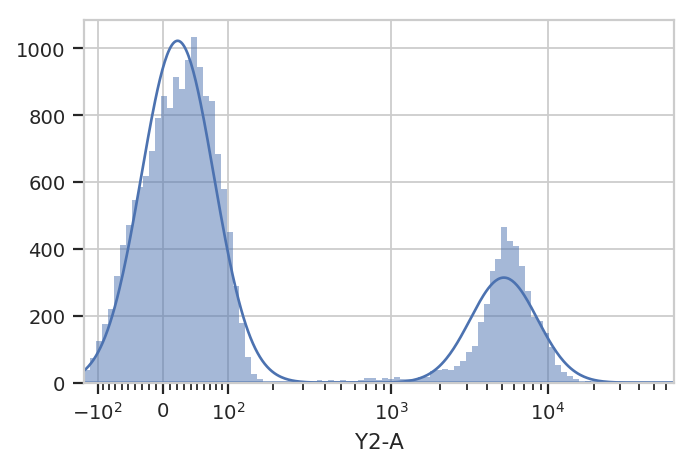

In [5]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["Y2-A"],
                           scale = {"Y2-A" : "logicle"},
                           num_components = 2)

g.estimate(ex)
g.default_view().plot(ex)

Excellent.  It looks like the GMM found the two distributions we were looking for.  Let's call `apply()`, then use the operation's default view to plot the new `Experiment`.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


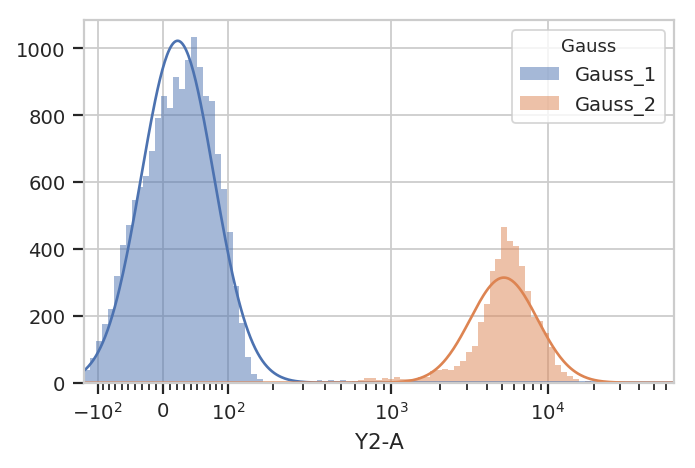

In [6]:
ex2 = g.apply(ex)
g.default_view().plot(ex2)

When you `apply()` the `GaussianMixtureModelOp`, it adds a new piece of metadata to each event in the data set:
a condition whose name that's the same as the name of the operation (in this case, `Gauss`).  
The values are `{Name}_{#}`, where `{Name}` is the name of the operation and `{#}` is which population had the  
highest posterior probability.  So, in this example the events would be labeled `Gauss_1` or `Gauss_2`.

In [7]:
ex2.data.head()

,Dox,V2-A,Y2-A,Gauss
0,10.0,41.593452,109.946274,Gauss_1
1,10.0,103.437637,5554.108398,Gauss_2
2,10.0,-271.375580,81.835281,Gauss_1
3,10.0,-26.212378,-54.120304,Gauss_1
4,10.0,44.559933,-10.542595,Gauss_1


We can use that new condition to plot or compute or otherwise operate on each of the populations separately:

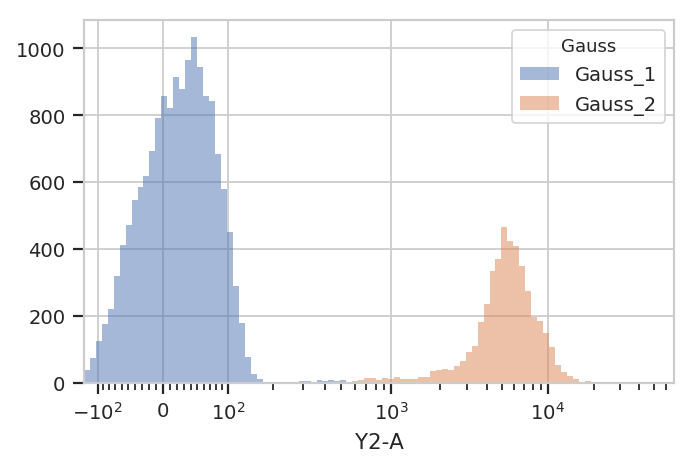

In [8]:
flow.HistogramView(channel = "Y2-A",
                   scale = "logicle",
                   huefacet = "Gauss").plot(ex2)

There's an important subtlety to notice here.  In the plot above, we set the data scale on the `HistogramView`, but prior to that we passed `scale = {"Y2-A" : "logicle"}` to the `GaussianMixtureOp` *operation*.  We did so in order to fit the gaussian model to the *scaled data*, as opposed to the raw data.  

This is an example of a broader design goal: in order to enable more quantitative analysis, `cytoflow` does not re-scale the underlying data; rather, it transforms it before displaying it.  Frequently it is useful to perform the same transformation before doing data-driven things, so many modules that have an `estimate()` function also allow you to specify a `scale`.

---

A 1-dimensional gaussian mixture model works well if the populations are well-separated.  However, if they're closer together, you may only want to keep events that are "clearly" in one distribution or another.  One way to accomplish this by passing a `sigma` parameter to `GaussianMixtureOp`.  This doesn't change the behavior of `estimate()`, but when you `apply()` the operation it creates new conditions, one for each population.  The conditions are named `{Name}_{#}`, where `{Name}` is the name of the operation and `{#}` is the index of the
population.  The value of the condition is `True` for an event if that event is within `sigma` standard deviations of the population mean.

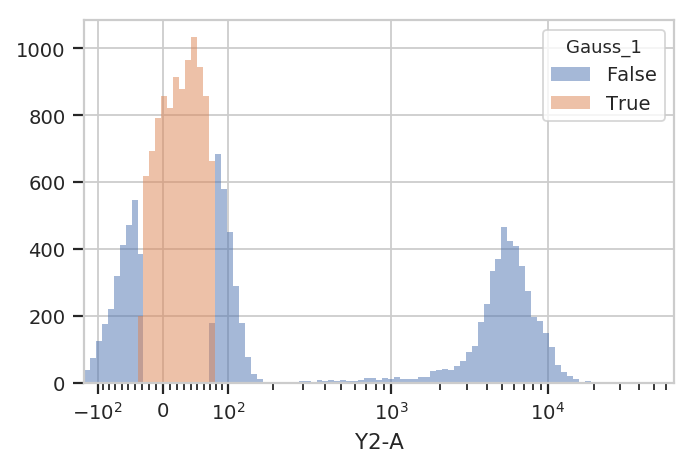

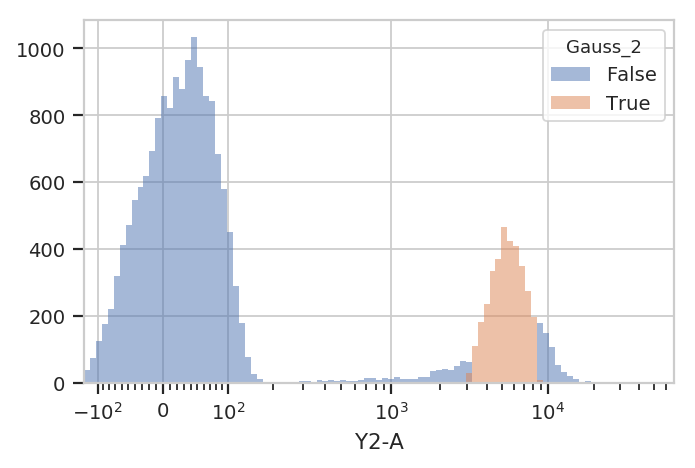

In [9]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["Y2-A"],
                           scale = {"Y2-A" : "logicle"},
                           num_components = 2,
                           sigma = 1)

g.estimate(ex)
ex2 = g.apply(ex)

flow.HistogramView(channel = "Y2-A",
                   huefacet = "Gauss_1",
                   scale = "logicle").plot(ex2)

flow.HistogramView(channel = "Y2-A",
                   huefacet = "Gauss_2",
                   scale = "logicle").plot(ex2)

Sometimes, mixtures are very close and separating them is difficult.  In such cases it may be better to filter the events based on the _posterior probability_ that they are actually members of the components to which they were assigned.  We can get this behavior by passing `posterior = True` as a parameter to `GaussianMixture1DOp`.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


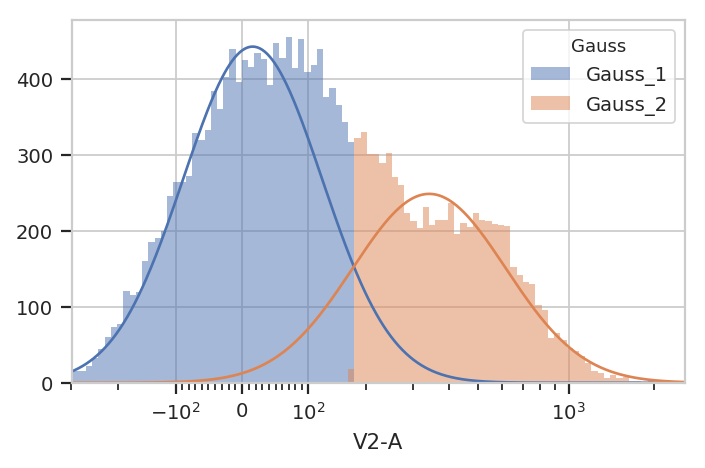

In [10]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["V2-A"],
                           scale = {"V2-A" : "logicle"},
                           num_components = 2,
                           posteriors = True)

g.estimate(ex)
ex2 = g.apply(ex)
g.default_view().plot(ex2)

If `posteriors = True`, the `GaussianMixtureOp.apply()` adds another metadata column, `{Name}_{#}_Posterior`, that contains the posterior probability of each event in that component.

In [11]:
ex2.data.head()

,Dox,V2-A,Y2-A,Gauss,Gauss_1_posterior,Gauss_2_posterior
0,10.0,41.593452,109.946274,Gauss_1,0.937407,0.062593
1,10.0,103.437637,5554.108398,Gauss_1,0.807580,0.192420
2,10.0,-271.375580,81.835281,Gauss_1,0.999598,0.000402
3,10.0,-26.212378,-54.120304,Gauss_1,0.983376,0.016624
4,10.0,44.559933,-10.542595,Gauss_1,0.933715,0.066285


We can use this second metadata column to filter out events with low posterior probabilities:

In [12]:
ex2.query("Gauss_1_posterior > 0.9 | Gauss_2_posterior > 0.9").data.head()

,Dox,V2-A,Y2-A,Gauss,Gauss_1_posterior,Gauss_2_posterior
0,10.0,41.593452,109.946274,Gauss_1,0.937407,0.062593
1,10.0,-271.375580,81.835281,Gauss_1,0.999598,0.000402
2,10.0,-26.212378,-54.120304,Gauss_1,0.983376,0.016624
3,10.0,44.559933,-10.542595,Gauss_1,0.933715,0.066285
4,10.0,38.142925,34.791252,Gauss_1,0.941456,0.058544


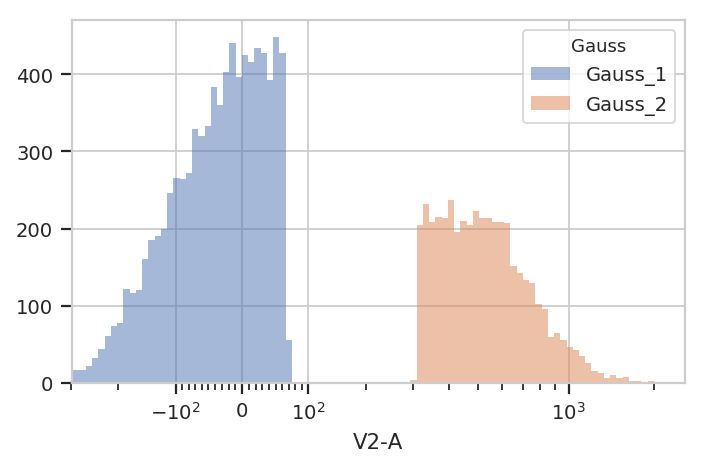

In [13]:
flow.HistogramView(channel = "V2-A",
                   huefacet = "Gauss",
                   scale = "logicle",
                   subset = "Gauss_1_posterior > 0.9 | Gauss_2_posterior > 0.9").plot(ex2)

Finally, sometimes you don't want to use the same model parameters for your entire data set.  Instead, you want to estimate different parameters for different subsets.  `cytoflow`'s data-driven modules allow you to do so with a `by` parameter, which _aggregates_ subsets before estimating model parameters.  You pass `by` an array of metadata columns, and the module estimates a new model for each unique subset of those metadata.

For example, let's look at the `V2-A` channel faceted by `Dox`:

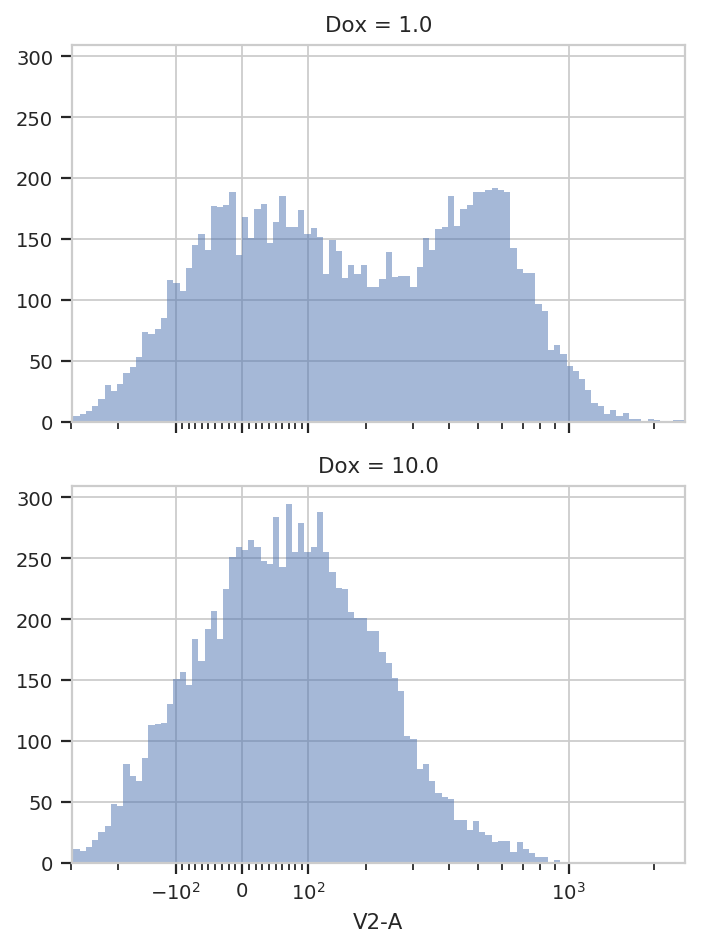

In [14]:
flow.HistogramView(channel = "V2-A", 
                   scale = "logicle",
                   yfacet = "Dox").plot(ex)

It's pretty clear that the `Dox == 1.0` condition and the `Dox == 10.0` condition are different; a single 2-component GMM won't fit both of them.  So let's fit a model to each unique value of `Dox`.  Note that `by` takes a *list* of metadata columns; you must pass it a list, even if there's only one element in the list.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


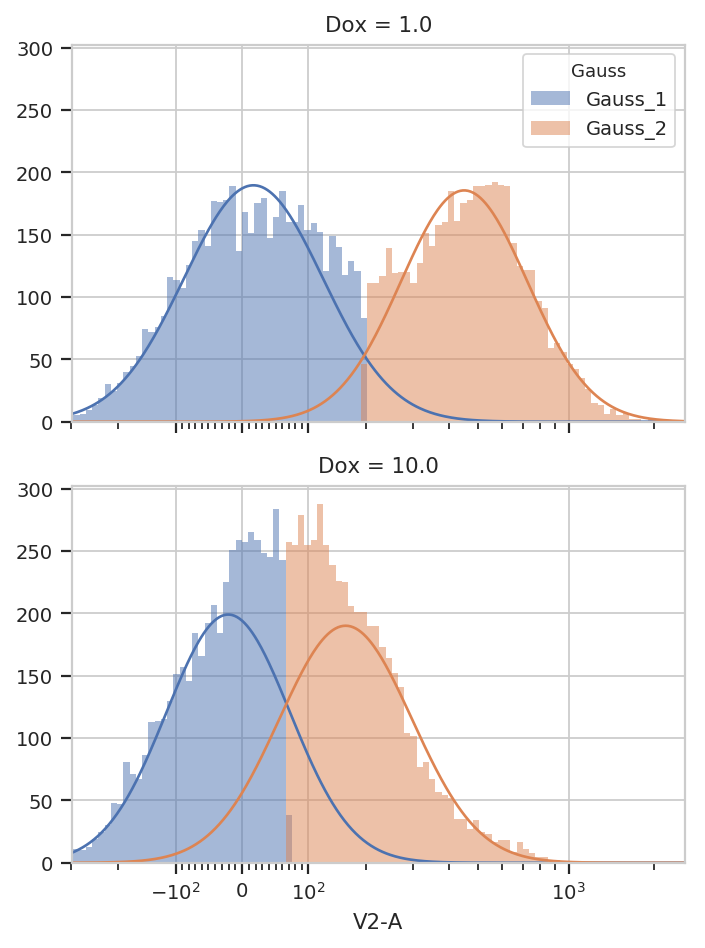

In [15]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["V2-A"],
                           scale = {"V2-A" : "logicle"},
                           num_components = 2,
                           by = ["Dox"])

g.estimate(ex)
ex2 = g.apply(ex)
g.default_view(yfacet = "Dox").plot(ex2)

You can see that the models for the two subsets are substantially different.

It is important to note that while the estimated model parameters differ between subsets, it is not currently possible to specify different _module parameters_ across subsets.  For example, you can't specify that the `Dox = 1.0` subset have two GMM components, but `Dox == 10.0` have only one.  If we could _estimate_ the number of components, on the other hand, using (say) an AIC or BIC information criterion, then different subsets could have different numbers of components.  For this kind of unsupervized algorithm, see the `FlowPeaksOp` example below.

# 2D Gaussian Mixture Models

Did you notice how we were setting the `channels` attribute of `GaussianMixtureOp` to a one-element list?  That's because `GaussianMixtureOp` will work in any number of dimensions.  Here's a similar workflow in two channels instead of one:

---

Basic usage, assigning each event to one of the mixture components:  (the isolines in the `default_view()` are 1, 2 and 3 standard deviations away from the mean.)

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


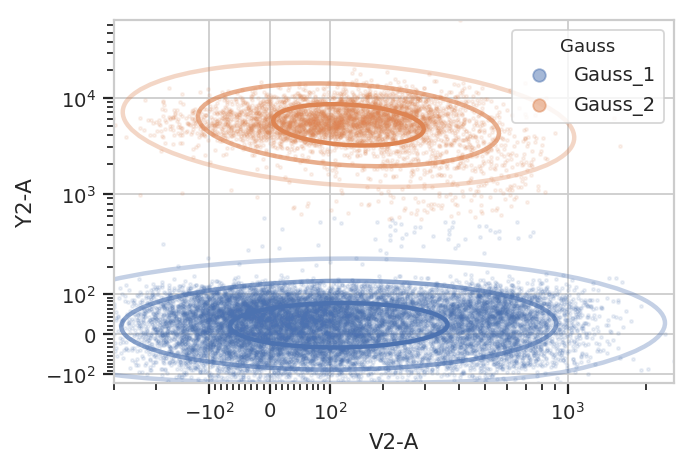

In [16]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["V2-A", "Y2-A"],
                           scale = {"V2-A" : "logicle",
                                    "Y2-A" : "logicle"},
                           num_components = 2)
g.estimate(ex)
ex2 = g.apply(ex)
g.default_view().plot(ex2, alpha = 0.1)

Subsetting based on standard deviation.  Note: we use the Mahalnobis distance as a multivariate generalization of the number of standard deviations an event is from the mean of the multivariate gaussian.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


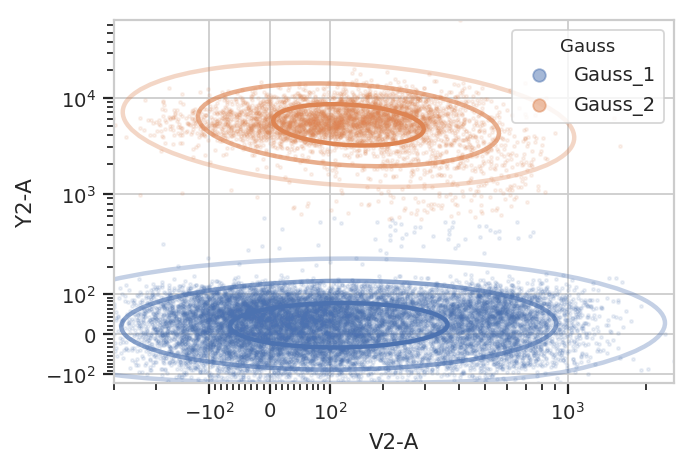

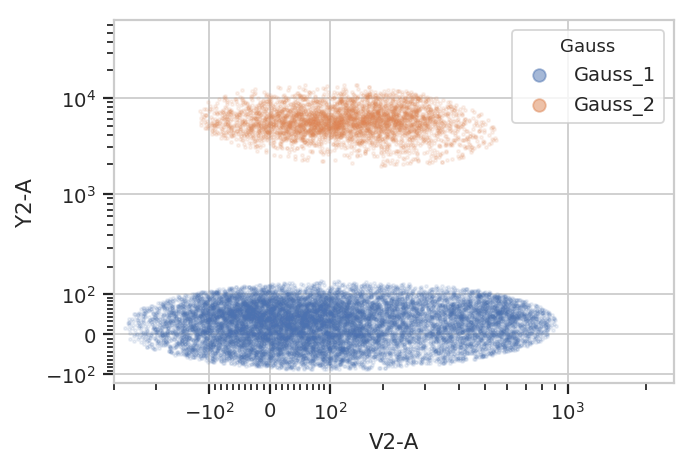

In [17]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["V2-A", "Y2-A"],
                           scale = {"V2-A" : "logicle",
                                    "Y2-A" : "logicle"},
                           num_components = 2,
                           sigma = 2)

g.estimate(ex)
ex2 = g.apply(ex)

g.default_view().plot(ex2, alpha = 0.1)

flow.ScatterplotView(xchannel = "V2-A",
                     ychannel = "Y2-A",
                     xscale = "logicle",
                     yscale = "logicle",
                     huefacet = "Gauss",
                     subset = "Gauss_1 == True | Gauss_2 == True").plot(ex2, alpha = 0.1)

Gating based on posterior probabilities:

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


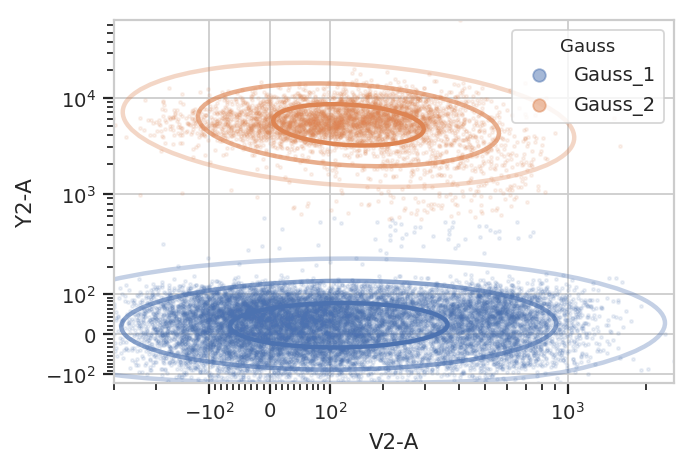

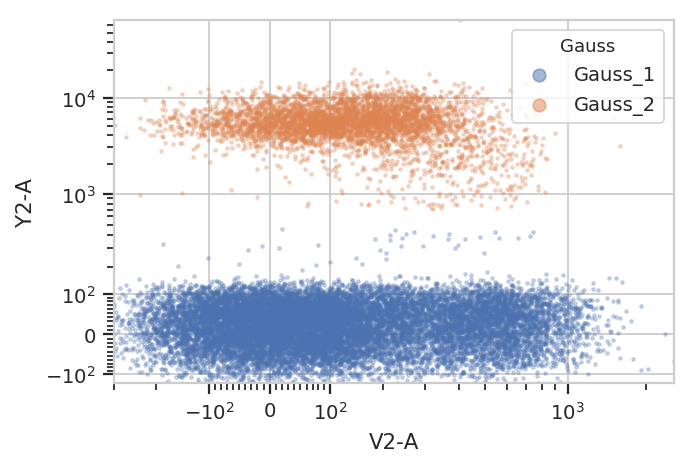

In [18]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["V2-A", "Y2-A"],
                           scale = {"V2-A" : "logicle",
                                    "Y2-A" : "logicle"},
                           num_components = 2,
                           posteriors = True)

g.estimate(ex)
ex2 = g.apply(ex)

g.default_view().plot(ex2, alpha = 0.1)

flow.ScatterplotView(xchannel = "V2-A",
                     ychannel = "Y2-A",
                     xscale = "logicle",
                     yscale = "logicle",
                     huefacet = "Gauss",
                     subset = "Gauss_1_posterior > 0.99 | Gauss_2_posterior > 0.99").plot(ex2)

And multiple models for different subsets:

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'Gauss'


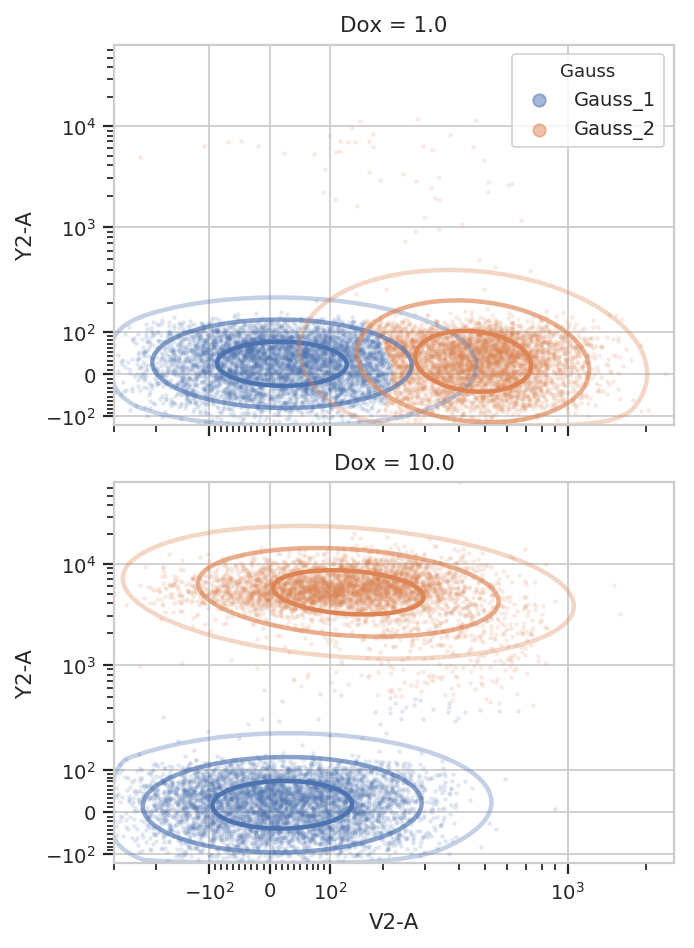

In [19]:
g = flow.GaussianMixtureOp(name = "Gauss",
                           channels = ["V2-A", "Y2-A"],
                           scale = {"V2-A" : "logicle",
                                    "Y2-A" : "logicle"},
                           num_components = 2,
                           by = ['Dox'])

g.estimate(ex)
ex2 = g.apply(ex)

g.default_view(yfacet = "Dox").plot(ex2, alpha = 0.1)

# K-Means

A gaussian mixture model can find clustered data, but it works best on clusters that are shaped like gaussian distributions (duh.)  K-means clustering is much more general.  As with the GMM operation, `cytoflow`'s K-means operation is N-dimensional and is parameterized very similarly.  Here's a demonstration in 2D.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'KMeans'


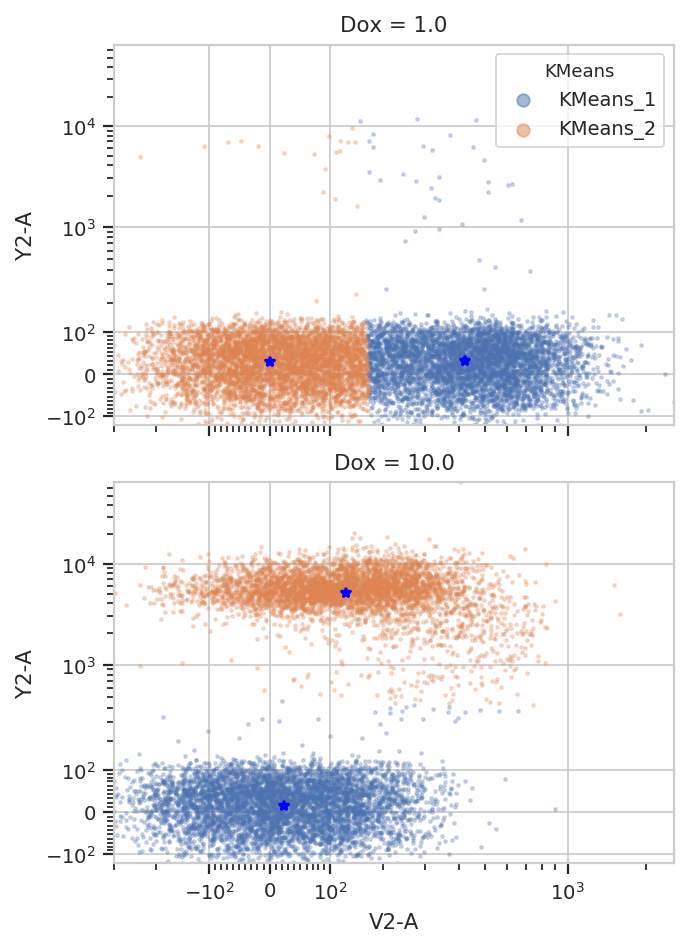

In [20]:
k = flow.KMeansOp(name = "KMeans",
                  channels = ["V2-A", "Y2-A"],
                  scale = {"V2-A" : "logicle",
                           "Y2-A" : "logicle"},
                  num_clusters = 2,
                  by = ['Dox'])

k.estimate(ex)
ex2 = k.apply(ex)
k.default_view(yfacet = "Dox").plot(ex2)

Note how the centroids are marked with blue stars.  The locations of the centroids are also saved as a new statistic:

In [21]:
ex2.statistics

{('KMeans', 'centers'): Dox   Cluster  Channel
 1.0   1        V2-A        420.424332
                Y2-A         29.304036
       2        V2-A          1.276445
                Y2-A         26.576759
 10.0  1        V2-A         23.096459
                Y2-A         14.118368
       2        V2-A        127.770348
                Y2-A       5113.999433
 dtype: float64}

# FlowPeaks

Sometimes you want to cluster a data set and K-means just doesn't work.  (It generally works best when clusters are fairly compact.)  In such cases, the unsupervized clustering algorith `flowPeaks` may work better for you.  For example, the following FCS file (of an E. coli experiment) shows clear separation between the cells (upper population) and the particulate matter in the media (lower population.)

In [22]:
ex = flow.ImportOp(tubes = [flow.Tube(file = 'data/ecoli.fcs')]).apply()

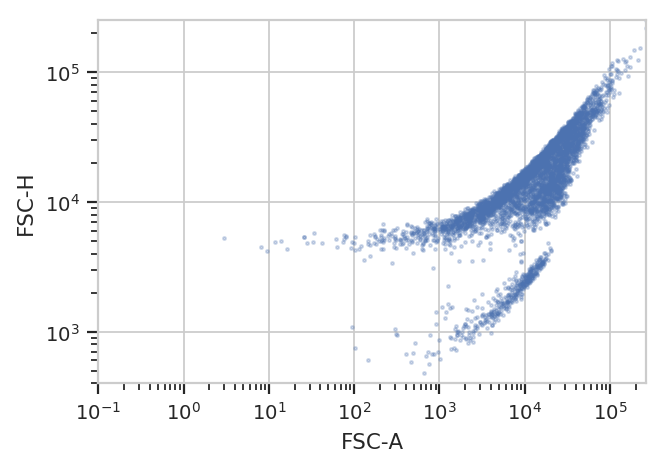

In [23]:
flow.ScatterplotView(xchannel = "FSC-A",
                     xscale = 'log',
                     ychannel = "FSC-H",
                     yscale = 'log').plot(ex)

Unfortunately, K-means (even with more clusters than I want) isn't finding them properly.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'KMeans'


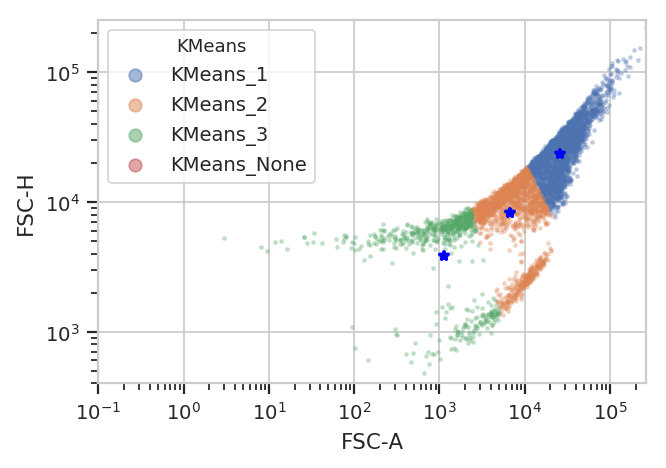

In [24]:
k = flow.KMeansOp(name = "KMeans",
                  channels = ["FSC-A", "FSC-H"],
                  scale = {"FSC-A" : "log",
                           "FSC-H" : "log"},
                  num_clusters = 3)

k.estimate(ex)
ex2 = k.apply(ex)
k.default_view().plot(ex2)

`flowPeaks` is an unsupervized learning strategy developed specifically for flow cytometry, and it works much better here.  It can automatically determine the number of "natural" clusters in a data set.  It is also much more computationally expensive -- if you have a large data set, be prepared to wait for a while!

Another note -- there are a number of hyperparameters for this method that can dramatically change how it operates.  The defaults are good for many data sets; for the one below, I had to decrease `h0` from `1.0` to `0.5`.  See the documentation for details.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'FP'


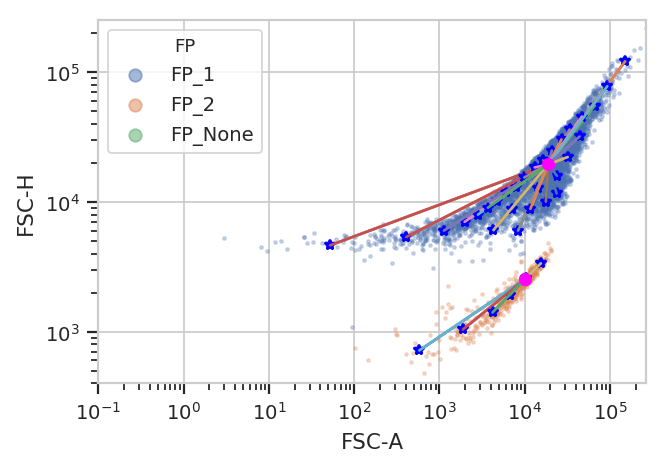

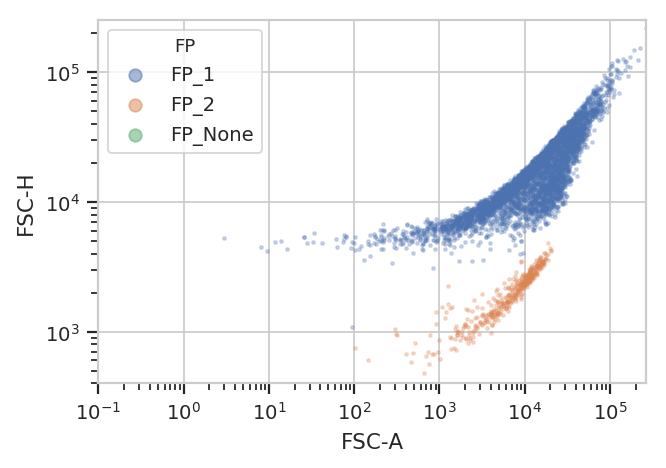

In [25]:
fp = flow.FlowPeaksOp(name = "FP",
                      channels = ["FSC-A", "FSC-H"],
                      scale = {"FSC-A" : "log",
                               "FSC-H" : "log"},
                      h0 = 0.5)

fp.estimate(ex)
ex2 = fp.apply(ex)
fp.default_view().plot(ex2)
flow.ScatterplotView(xchannel = "FSC-A",
                     xscale = "log",
                     ychannel = "FSC-H",
                     yscale = "log",
                     huefacet = "FP").plot(ex2)